## 应用线性回归预测医疗费用

公司为了赚钱，保险需要募集比花费在受益者的医疗服务上更多的年度保费，因此，保险公司投入了大量的时间和金钱来研发能精确预测医疗费用的模型。

医疗费用很难估计，因为花费最高的情况是罕见的而且似乎是随机的。但是有些情况对于特定的群体还是比较普遍存在的。例如，吸烟者比不吸烟者得肺癌的可能性更大，肥胖的人更有可能得心脏病。

此分析的目的是利用病人的数据来预测这部分群体的平均医疗费用。这些估计可以用来创造一个精算表，根据预期的治疗费用来设定年度保费价格是高一点还是低一点。

### 1 收集数据

为了便于分析，我们使用一个模拟数据集，该数据集包含了美国病人的医疗费用。基于美国人口普查局（U.S.Census Bureau）的人口统计资料整理得出的insurance.csv，包含1338个案例，即目前已经登记过的保险计划受益者以及表示病人特点和历年计划计入的总的医疗费用的特征。这些特征是：

* age：这是一个整数，表示主要受益者的年龄（不包括超过64岁的人，因为他们一般由政府支付）。

* sex：这是保单持有人的性别，要么是male，要么是female。

* bmi：这是身体质量指数（Body Mass Index, BMI），它提供了一个判断人的体重相对于身高是过重还是偏轻的方法，BMI指数等于体重（公斤）除以身高（米）的平方。

* children：这是一个整数，表示保险计划中所包括的孩子/受抚养者的数量。

* smoker：根据被保险人是否吸烟判断yes或者no。

* region：根据受益人在美国的居住地，分为4个地理区域：northeast、southeastern、southwest和northwest。

如何将这些变量与已结算的医疗费用联系在一起是非常重要的。例如，我们可能认为老年人和吸烟者在大额医疗费用上有较高的风险。与许多其他的机器学习方法不同，在回归分析中，特征之间的关系通常由使用者指定而不是自动检测出来。在下一节中，我们将探讨其中的一些潜在关系。

### 2 探索和准备数据

首先，使用pandas的read_csv()函数读入数据。

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
#insurance = pd.read_csv("insurance.csv")
#insurance = pd.read_csv("D:/2020春季学期授课/数据科学导论/第三周上课/医疗费用预测/datasetinsurance.csv")
insurance=pd.read_csv("D:/Data_Science/dataset/insurance.csv")
insurance.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


既然因变量是charges，那么让我们一起来看一看它是如何分布的：

In [14]:
insurance["charges"].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

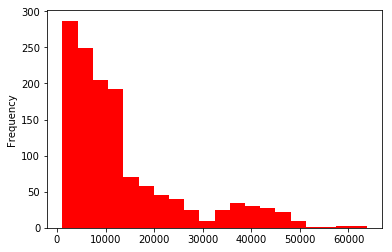

In [19]:
insurance["charges"].plot(kind='hist',color='red',bins=20)

因为平均值远大于中位数，所以这表明保险费用的分布是右偏的。我们可以使用直观的直方图来证实这一点，用pylab模块中的hist()函数即可画出直方图

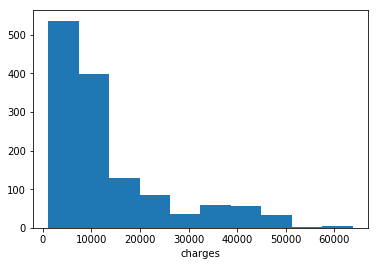

In [16]:
import pylab as pl
pl.hist(insurance["charges"])
pl.xlabel('charges')
pl.show()

在我们的数据中，绝大多数的个人每年的医疗费用都在0~15000美元，尽管分布的尾部经过直方图的峰部后延伸得很远。因为线性回归假设因变量的分布为正态分布，所以这种分布是不理想的。在实际应用中，线性回归的假设往往会被违背。如果需要，我们在后面能够修正该假设。

即将面临的另一个问题就是回归模型需要每一个特征都是数值型的，而在我们的数据中，我们有3个非数值类型的特征。

变量sex被划分成male和female两个水平，而变量smoker被划分成yes和no两个水平。从describe()的输出中，我们知道变量region有4个水平，但我们需要仔细看一看，它们是如何分布的。

In [20]:
insurance["sex"].describe()

count     1338
unique       2
top       male
freq       676
Name: sex, dtype: object

In [21]:
insurance["smoker"].describe()

count     1338
unique       2
top         no
freq      1064
Name: smoker, dtype: object

In [22]:
insurance["region"].describe()

count          1338
unique            4
top       southeast
freq            364
Name: region, dtype: object

In [23]:
insurance.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

这里，我们看到数据几乎均匀地分布在4个地理区域中。

### 探索特征之间的关系——相关系数矩阵

在使用回归模型拟合数据之前，有必要确定自变量与因变量之间以及自变量之间是如何相关的。相关系数矩阵（correlation matrix）提供了这些关系的快速概览。给定一组变量，它可以为每一对变量之间的关系提供一个相关系数。

为insurance中的4个数值型变量创建一个相关系数矩阵，可以使用corr()命令：

In [24]:
insurance[["age","bmi","children","charges"]].corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


在每个行与列的交叉点，列出的相关系数表示其所在的行与其所在的列的两个变量之间的相关系数。对角线始终为1，因为一个变量和其自身之间总是完全相关的。因为相关性是对称的，换句话说就是，corr(x,y) = corr(y,x)，所以对角线上方的值与其下方的值是相同的。

该矩阵中的相关系数不是强相关的，但还是存在一些显著的关联。例如，age和bmi显示出中度相关，这意味着随着年龄（age）的增长，身体质量指数（bmi）也会增加。此外，age和charges，bmi和charges，以及children和charges也都呈现出中度相关。当我们建立最终的回归模型时，我们会尽量更加清晰地梳理出这些关系。

### 3 基于数据训练模型

用Python对数据拟合一个线性回归模型，可以使用sklearn包的线性模型类linear_model中的函数LinearRegression()。

在此之前，我们注意到，sex、smoker和region这三个变量均为类别变量，而非数值型。

R语言中的线性回归函数lm()可自动将一种称为虚拟编码（dummy coding）的技术应用于模型所包含的每一个因子类型的变量中。虚拟编码允许名义特征通过为一个特征的每一类创建一个二元变量来将其处理成数值型变量，即如果观测值属于某一类，那就设定为1，否则设定为0。例如，性别（sex）变量有两类：男性（male）和女性（female）。这将分为两个二进制值变量，R中将其命名为sexmale和sexfemale。对于观测值，如果sex=male，那么sexmale=1、sexfemale=0；如果sex=female，那么sexmale=0、sexfemale=1。相同的编码适用于有3个类别甚至更多类别的变量，具有4个类别的特征region可以分为4个变量：regionnorthwest、regionsoutheast、regionsouthwest、regionnortheast。当添加一个虚拟编码的变量到回归模型中时，一个类别总是被排除在外作为参照类别。然后，估计的系数就是相对于参照类别解释的。以上思想，是我们在面对定性因素时的常用处理手段。它可以帮助我们将定性变量进行量化，已达到定性因素能与定量因素有着相同作用之目的。

在Python语言中，似乎没有现成的回归函数来直接实现虚拟变量回归。因此，我们需要先对上述三个类别变量进行虚拟编码，如下定义函数dummycoding()。

In [26]:
def dummycoding(dataframe):
        
        dataframe_age = dataframe['age']
        dataframe_bmi = dataframe['bmi']
        dataframe_children = dataframe['children']
        dataframe_charges = dataframe['charges']
        dataframe_1 = dataframe.drop(['age'], axis = 1)
        dataframe_2 = dataframe_1.drop(['bmi'], axis = 1)
        dataframe_3 = dataframe_2.drop(['children'], axis = 1)
        dataframe_new = dataframe_3.drop(['charges'], axis = 1)
        
        dataframe_new=pd.get_dummies(dataframe_new, prefix = dataframe_new.columns).astype(int)
        
        dataframe_new['age'] = dataframe_age
        dataframe_new['bmi'] = dataframe_bmi
        dataframe_new['children'] = dataframe_children
        dataframe_new['charges'] = dataframe_charges
        return dataframe_new
    
insurance_lm=dummycoding(insurance)

insurance_lm.head(10)

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children,charges
0,1,0,0,1,0,0,0,1,19,27.900,0,16884.92400
1,0,1,1,0,0,0,1,0,18,33.770,1,1725.55230
2,0,1,1,0,0,0,1,0,28,33.000,3,4449.46200
3,0,1,1,0,0,1,0,0,33,22.705,0,21984.47061
4,0,1,1,0,0,1,0,0,32,28.880,0,3866.85520
5,1,0,1,0,0,0,1,0,31,25.740,0,3756.62160
6,1,0,1,0,0,0,1,0,46,33.440,1,8240.58960
7,1,0,1,0,0,1,0,0,37,27.740,3,7281.50560
8,0,1,1,0,1,0,0,0,37,29.830,2,6406.41070
9,1,0,1,0,0,1,0,0,60,25.840,0,28923.13692


如上表所示，我们已经完成了对insurance中类型变量的虚拟编码。然后在回归模型中保留sex_female、smoker_no和region_northeast变量，使东北地区的女性非吸烟者作为参照组。

In [27]:
from sklearn import linear_model

insurance_lm_y = insurance_lm['charges']
insurance_lm_X1 = insurance_lm.drop(['charges'], axis = 1)
insurance_lm_X2 = insurance_lm_X1.drop(['sex_female'], axis = 1)
insurance_lm_X3 = insurance_lm_X2.drop(['smoker_no'], axis = 1)
insurance_lm_X = insurance_lm_X3.drop(['region_northeast'], axis = 1)

In [28]:
insurance_lm_X.head(10)

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,age,bmi,children
0,0,1,0,0,1,19,27.900,0
1,1,0,0,1,0,18,33.770,1
2,1,0,0,1,0,28,33.000,3
3,1,0,1,0,0,33,22.705,0
4,1,0,1,0,0,32,28.880,0
5,0,0,0,1,0,31,25.740,0
6,0,0,0,1,0,46,33.440,1
7,0,0,1,0,0,37,27.740,3
8,1,0,0,0,0,37,29.830,2
9,0,0,1,0,0,60,25.840,0


In [29]:
insurance_lm_y.head(10)

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
5     3756.62160
6     8240.58960
7     7281.50560
8     6406.41070
9    28923.13692
Name: charges, dtype: float64

In [30]:
regr = linear_model.LinearRegression()
regr.fit(insurance_lm_X, insurance_lm_y)

print('Intercept: %.2f'
      % regr.intercept_)
print('Coefficients: ')
print(regr.coef_)
print('Residual sum of squares: %.2f'
      % np.mean((regr.predict(insurance_lm_X) - insurance_lm_y) ** 2))
print('Variance score: %.2f' % regr.score(insurance_lm_X, insurance_lm_y))

Intercept: -11938.54
Coefficients: 
[ -131.3143594  23848.53454191  -352.96389942 -1035.02204939
  -960.0509913    256.85635254   339.19345361   475.50054515]
Residual sum of squares: 36501893.01
Variance score: 0.75


regr = linear_model.LinearRegression()
regr.fit(insurance_lm_X, insurance_lm_y)

print('Intercept: %.2f'
      % regr.intercept_)
print('Coefficients: ')
print(regr.coef_)
print('Residual sum of squares: %.2f'
      % np.mean((regr.predict(insurance_lm_X) - insurance_lm_y) ** 2))
print('Variance score: %.2f' % regr.score(insurance_lm_X, insurance_lm_y))

### 4 评估模型的性能

读者通过与同一案例R版本的对比可知，在评估模型性能这一方面，R中的lm()函数的结果输出更加完善。用scikit-learn构建线性回归时，很多性能指标是无法直接查看的，因为sklearn是一个机器学习库而非统计库。有兴趣的读者可以自行尝试定义相关性能指标函数。由于R版本中已经对各项性能指标进行了分析，这里我们不再赘述。

### 5 提高模型的性能
正如前面所提到的，回归模型和其他机器学习方法的一个关键区别就在于回归通常会让使用者来选择特征和设定模型。因此，如果我们有关于一个特征是如何与结果相关的学科知识，我们就可以使用该信息来对模型进行设定，并可能提高模型的性能。

* 1 模型的设定——添加非线性关系
在线性回归中，自变量和因变量之间的关系呗假定为是线性的，然而这不一定是正确的。例如，对所有的年龄值来讲，年龄对于医疗费用的影响可能不是恒定的；对于最老的人群，治疗可能会过于昂贵。

如果你还记得，一个典型的回归方程遵循如下的类似形式： y=α+β1xy=α+β1x 
考虑到非线性关系，可以添加一个高阶项到回归模型中，把模型当做多项式处理。实际上，我们将建立一个如下所示的关系模型： y=α+β1x+β2x2y=α+β1x+β2x2 
这两个模型之间的区别在于将估计一个单独的 β2β2 ，其目的是捕捉 x2x2 项的效果，这允许通过一个年龄的平方项来度量年龄的影响。

为了将非线性年龄添加到模型中，我们只需要创建一个新的变量：

In [31]:
insurance_lm['age2'] = insurance_lm['age']*insurance_lm['age']
insurance_lm['age2'].head(10)

0     361
1     324
2     784
3    1089
4    1024
5     961
6    2116
7    1369
8    1369
9    3600
Name: age2, dtype: int64

2 转换——将一个数值型变量转换为一个二进制指标
假设我们有一种预感，一个特征的影响不是累积的，而是当特征的取值达到一个给定的阈值后才产生影响。例如，对于在正常体重范围内的个人来说，BMI对医疗费用的影响可能为0，但是对于肥胖者（即BMI不低于30）来说，它可能与较高的费用密切相关。

我们可以通过创建一个二进制指标变量来建立这种关系，即如果BMI大于等于30，那么设定为1，否则设定为0。该二元特征的 ββ 估计表示BMI大于等于30的个人相对于BMI小于30的个人对医疗费用的平均净影响。

In [32]:
insurance_lm['bmi30'] = 0

for i in range(0, 1338):
    if insurance_lm['bmi'][i] >= 30 :
        insurance_lm['bmi30'][i] = 1
    else:
        insurance_lm['bmi30'][i] = 0

insurance_lm['bmi30'].head(10)

C:\Users\xdchen\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\xdchen\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0    0
1    1
2    1
3    0
4    0
5    0
6    1
7    0
8    0
9    0
Name: bmi30, dtype: int64

然后，可以在改进的模型中包含bmi30的变量，无论是取代原来的bmi变量，还是作为补充，这取决于我们是否认为除了一个单独的BMI影响外，肥胖的影响也会发生。如果没有很好的理由不这样做，那么我们将在最后的模型中包含两者。

如果你在决定是否要包含一个变量时遇到困难，一种常见的做法就是包含它并检验其显著性水平。然后，如果该变量在统计上不显著，那么就有证据支持在将来排除该变量。

###  3 模型的设定——加入相互作用的影响

到目前为止，我们只考虑了每个特征对结果的单独影响（贡献）。如果某些特征对因变量有综合影响，那么该怎么办呢？例如，吸烟和肥胖可能分别都有有害的影响，但是假设它们的共同影响可能会比它们每一个单独影响更糟糕是合理的。

当两个特征存在共同的影响时，这称为相互作用（interaction）。如果怀疑两个变量相互作用，那么可以通过在模型中添加它们的相互作用来检验这一假设，可以使用R中的公式语法来指定相互作用的影响。为了体现肥胖指标（bmi30）和吸烟指标（smoker）的相互作用，可以将bmi30 ∗∗ smoker_yes也作为自变量放入模型。

### 4 全部放在一起——一个改进的回归模型

基于医疗费用如何与患者特点联系在一起的一点学科知识，我们开发了一个我们认为更加精确专用的回归公式。下面就总结一下我们的改进：

增加了一个非线性年龄项

为肥胖创建了一个指标

制定了肥胖和吸烟之间的相互作用

我们将像之前一样使用回归函数来训练模型，但是这一次，我们将添加新构造的变量和相互作用项：

In [33]:
insurance_lm['bmi30_smoker']=insurance_lm['bmi30']*insurance_lm['smoker_yes']
insurance_lm.head(15)

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age,bmi,children,charges,age2,bmi30,bmi30_smoker
0,1,0,0,1,0,0,0,1,19,27.900,0,16884.92400,361,0,0
1,0,1,1,0,0,0,1,0,18,33.770,1,1725.55230,324,1,0
2,0,1,1,0,0,0,1,0,28,33.000,3,4449.46200,784,1,0
3,0,1,1,0,0,1,0,0,33,22.705,0,21984.47061,1089,0,0
4,0,1,1,0,0,1,0,0,32,28.880,0,3866.85520,1024,0,0
5,1,0,1,0,0,0,1,0,31,25.740,0,3756.62160,961,0,0
6,1,0,1,0,0,0,1,0,46,33.440,1,8240.58960,2116,1,0
7,1,0,1,0,0,1,0,0,37,27.740,3,7281.50560,1369,0,0
8,0,1,1,0,1,0,0,0,37,29.830,2,6406.41070,1369,0,0
9,1,0,1,0,0,1,0,0,60,25.840,0,28923.13692,3600,0,0


In [34]:
insurance_lm_y = insurance_lm['charges']
insurance_lm_X1 = insurance_lm.drop(['charges'], axis = 1)
insurance_lm_X2 = insurance_lm_X1.drop(['sex_female'], axis = 1)
insurance_lm_X3 = insurance_lm_X2.drop(['smoker_no'], axis = 1)
insurance_lm_X = insurance_lm_X3.drop(['region_northeast'], axis = 1)

regr = linear_model.LinearRegression()
regr.fit(insurance_lm_X, insurance_lm_y)

print('Intercept: %.2f'
      % regr.intercept_)
print('Coefficients: ')
print(regr.coef_)
print('Residual sum of squares: %.2f'
      % np.mean((regr.predict(insurance_lm_X) - insurance_lm_y) ** 2))
print('Variance score: %.2f' % regr.score(insurance_lm_X, insurance_lm_y))

Intercept: 134.25
Coefficients: 
[-4.96824457e+02  1.34046866e+04 -2.79203806e+02 -8.28546726e+02
 -1.22264365e+03 -3.26851487e+01  1.20019552e+02  6.78561198e+02
  3.73157552e+00 -1.00014032e+03  1.98107533e+04]
Residual sum of squares: 19578928.42
Variance score: 0.87


分析该模型的拟合统计量有助于确定我们的改变是否提高了回归模型的性能。相对于我们的第一个模型，R方值从0.75提高到约0.87，我们的模型现在能解释医疗费用变化的87%。肥胖和吸烟之间的相互作用表明了一个巨大的影响，除了单独吸烟增加的超过13404美元的费用外，肥胖的吸烟者每年要另外花费19810美元，这可能表明吸烟会加剧（恶化）与肥胖有关的疾病。